In [1]:
import pandas as pd 
import numpy as np
import re 
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno 

# TASK 
##### what sorts of people were more likely to survive the **titanic** shipwreck ?

In [2]:
# Setting pandas options 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = (10,8)

In [3]:
data = pd.read_csv('train.csv')

### GETTING FAMILIAR WITH THE DATASET

In [4]:
# First few rows
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Summary of dataset 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##### FEATURE DESCRIPTION 

- There are 12 features and 891 observations in the dataset 
- 7 Numeric features 
- 4 nominal features
- 1 ordinal feature 

| Feature         | Definition           | key  |
| ------------- |:-------------:| -----:|
| survival    | Survival | 0 = No, 1 = Yes |
|pclass     | Ticket class      |   1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex     |     |
| Age | Age in years|    |
| sibsp | # of siblings / spouses aboard the Titanic|   |  |
| parch | # of parents / children aboard the Titanic	|  |
| ticket | Ticket number |    |
| fare | Passenger fare |   |
| cabin | Cabin number |   |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton|

### DATA PREP

In [6]:
# Checking for duplicate records 
data.loc[data.duplicated()] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [7]:
(data.Name.value_counts() > 1).sum()

0

Observations 
- There are no duplicate records within the dataset 

In [8]:
# Checking for missing values 
pd.DataFrame(zip(data.isna().sum().index, data.isna().sum().values,
                 round(data.isna().mean() * 100, 2).values),
             columns = ['features', 'count_mv', 'perc_mv']).set_index('features')

,count_mv,perc_mv
features,,
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00


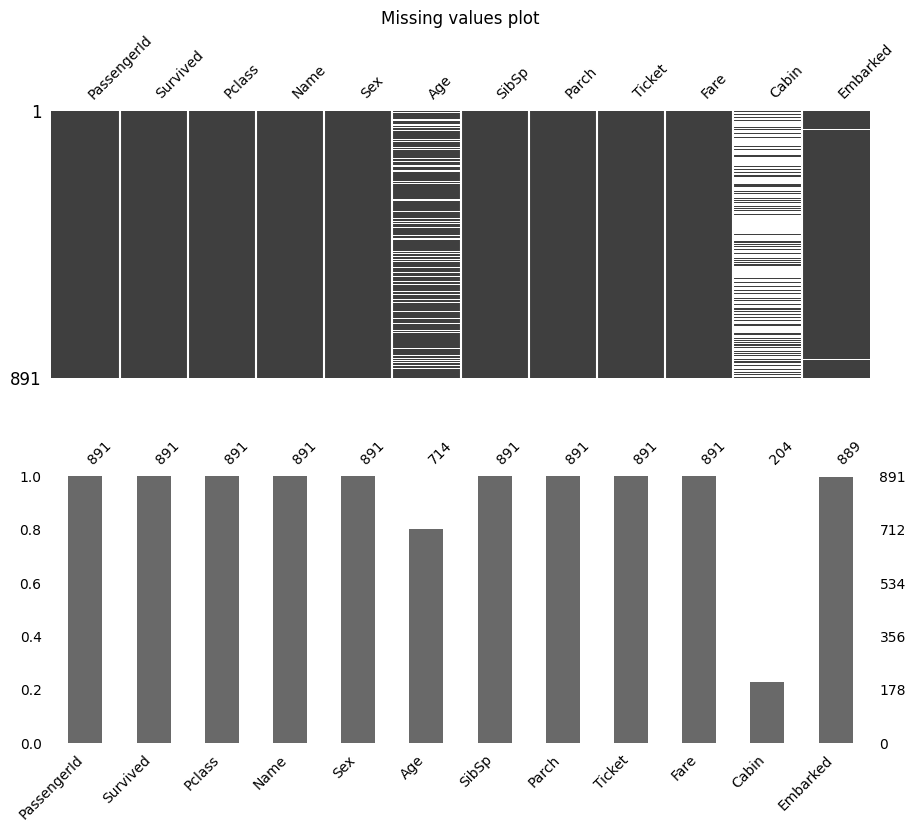

In [9]:
fig, (ax1, ax2) = plt.subplots(2)
fig.tight_layout(pad=5)
msno.matrix(data,  ax = ax1, fontsize = 10, sparkline = False)
msno.bar(data, ax = ax2, fontsize = 10)
ax1.set_title('Missing values plot')
# ax1.tick_params(axis='both', labelsize=10)
# ax2.tick_params(axis='both', labelsize=10)
plt.show()

Observations 
- The Age, Cabin and Embarked features have missing data
- The cabin feature has a high percentage(77%) of missing data (Feature will be dropped)

### EDA 

#### Quantitative features 

##### UNIVARIATE ANALYSIS

In [10]:
# Continuous features
cont_feat = data.dtypes[data.dtypes == 'float'].index 

# Discrete features 
disc_feat = data.dtypes[data.dtypes == 'int'].index[2:] # Excluding "PassengerId" and Target feature "Survived"


In [11]:
cont_feat

Index(['Age', 'Fare'], dtype='object')

In [12]:
disc_feat

Index(['Pclass', 'SibSp', 'Parch'], dtype='object')

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


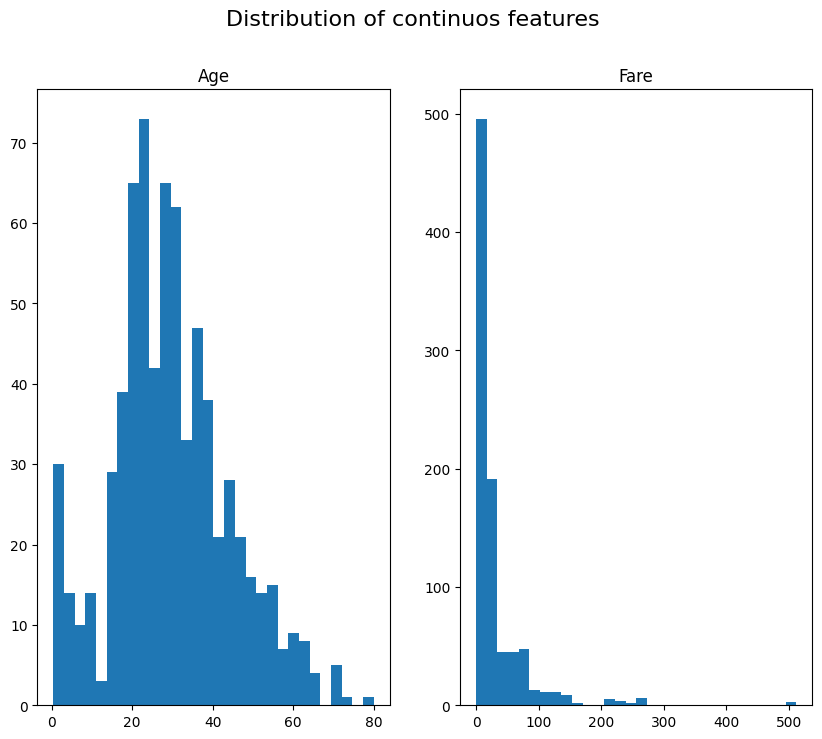

In [13]:
# Distribution of continuos features 
fig, ax = plt.subplots(1,2)
ax[0].hist(data = data, x = 'Age', bins = 30)
ax[0].set_title('Age')
ax[1].hist(data = data, x = 'Fare', bins = 30)
ax[1].set_title('Fare')
fig.suptitle('Distribution of continuos features', fontsize=16)

data[['Age', 'Fare']].describe()

Observations 
- The Age feature is slighly right skewwed(Possible presence of outlier values). A max value of 80 eliminates the possibility of outliers as this is a realistic age of an individual.

- Most passengers are between the age of 20-30

- The Fare feature is right skewwed(Possible presence of outlier values). Has a max value of 512.3292 (Needs more investigation)


In [14]:
# Investigating the Fare feature 
data[data['Fare'] == 512.3292]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


Observations 
- More than one passenger paid this amount 
- All passengers who paid this amount are first class passengers
- All passengers who paid this amount boarded the ship from Cherbourg 

With these finding the possibility of this value being an outlier is low 


In [15]:
# Relationship between Continuos features and Target feature
def age_groups(col):
#     if pd.notna(data[col]):
    if col <= 17:
        return 'child'

    elif col == 18 or col <= 30:
        return 'young_adult'

    elif col == 31 or col <= 45:
        return 'middle_aged_adult'

    elif col >= 45:
        return 'old_aged_adult'
    else:
        return col

In [16]:
data_copy = data.copy()
data_copy['Age_group'] = data_copy['Age'].apply(age_groups)

In [17]:
data_copy['Age_group'].value_counts()

young_adult          296
middle_aged_adult    202
child                113
old_aged_adult       103
Name: Age_group, dtype: int64

<AxesSubplot: xlabel='Age_group', ylabel='count'>

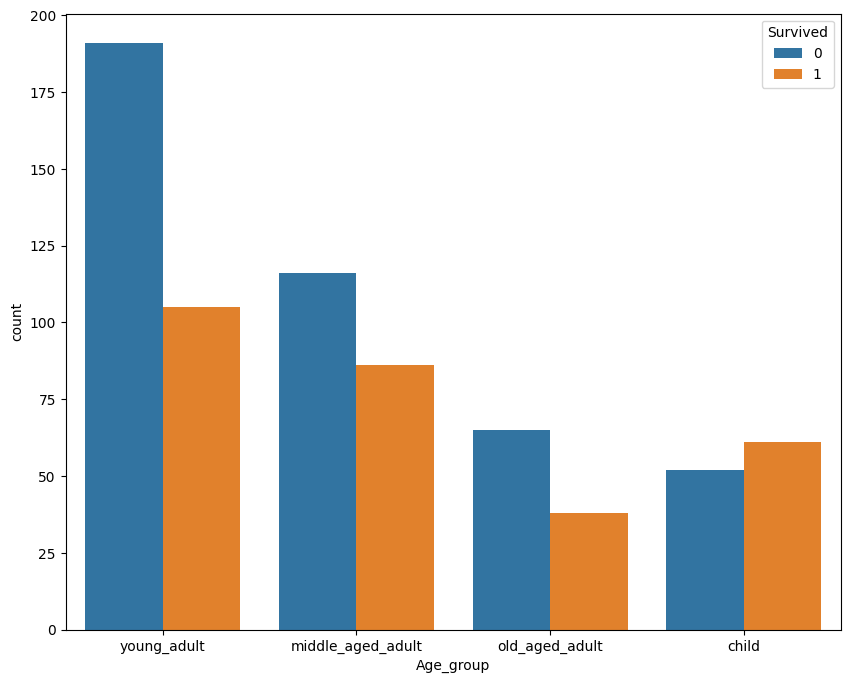

In [18]:
sns.countplot(data_copy, x = 'Age_group', hue = 'Survived')

In [19]:
def fare_groups(col):
#     if pd.notna(data[col]):
    if col == 0:
        return 'free'

    elif col == 1 or col <= 100:
        return 'cheap'

    elif col == 101 or col <= 250:
        return 'average'

    elif col >= 251:
        return 'expensive'
    else:
        return col

In [20]:
data_copy['Fare_group'] = data_copy['Fare'].apply(fare_groups)

<AxesSubplot: xlabel='Fare_group', ylabel='count'>

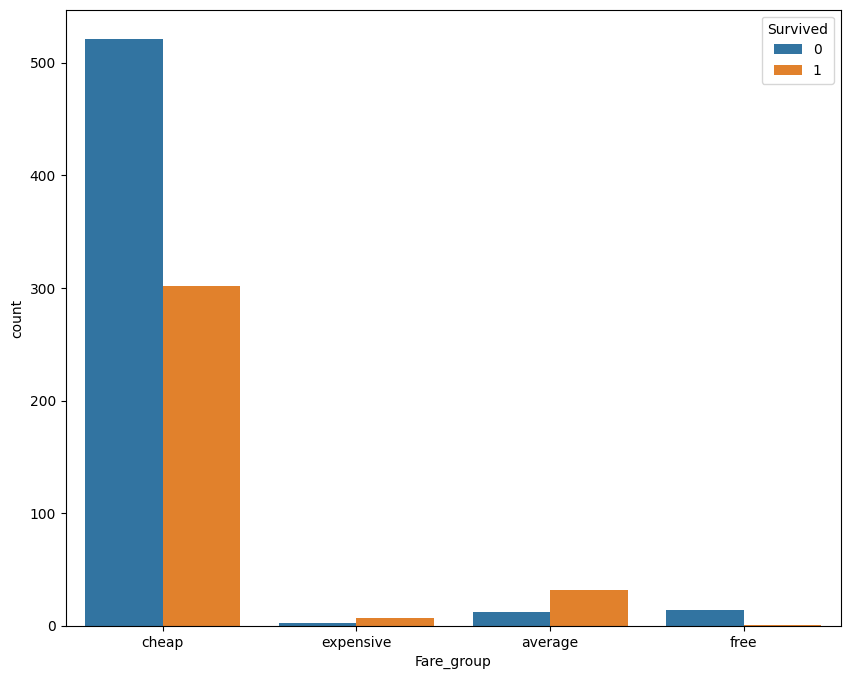

In [21]:
sns.countplot(data_copy, x = 'Fare_group', hue = 'Survived')

Observations
- There were more young adults on board the ship than any other age group 
- More children survived than died, unlike other age groups *
- More Passengers who paid average and expensive fares survived than died, unlike free and cheap fare groups 


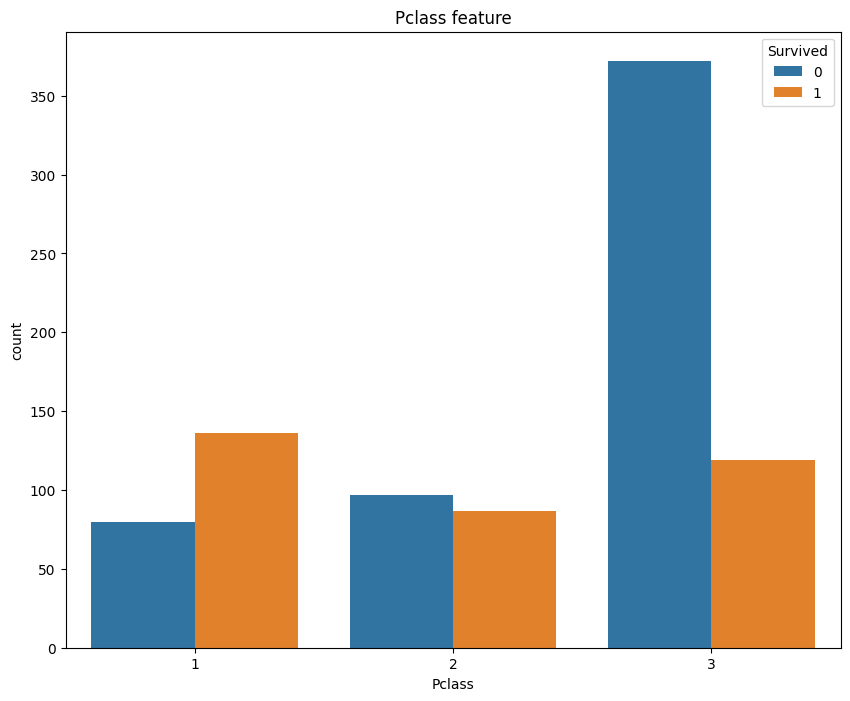

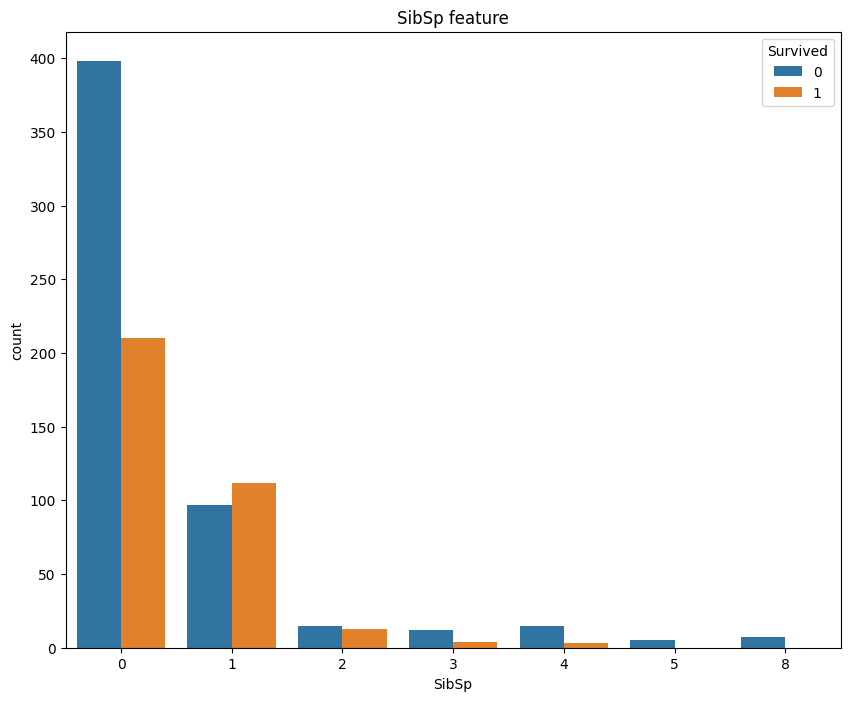

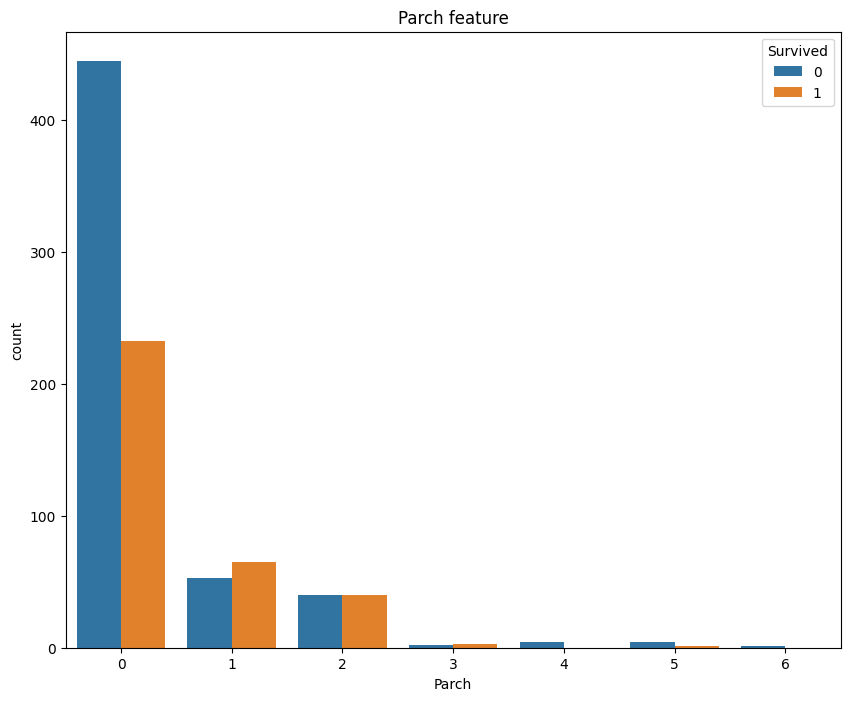

In [22]:
# Relationship between Discrete features and Target feature 
for feat in disc_feat:
    sns.countplot(data_copy, hue = 'Survived', x = feat).set(title = f"{feat} feature")
    plt.show()
    

Observations 
- Most  passengers were in 3rd class 
- More passengers in 1st class survived than died 
- Most passengers were travelling alone (without siblings/spouses/parents/children)
- More Passengers traveling with a siblings/spouses/parents/child survived than died 

### Categorical features 

In [23]:
cat_feat = [col for col in data_copy.columns if data_copy[col].dtype == 'O' and col not in ['Name', 'Ticket', 'Cabin']]

In [24]:
cat_feat 

['Sex', 'Embarked', 'Age_group', 'Fare_group']

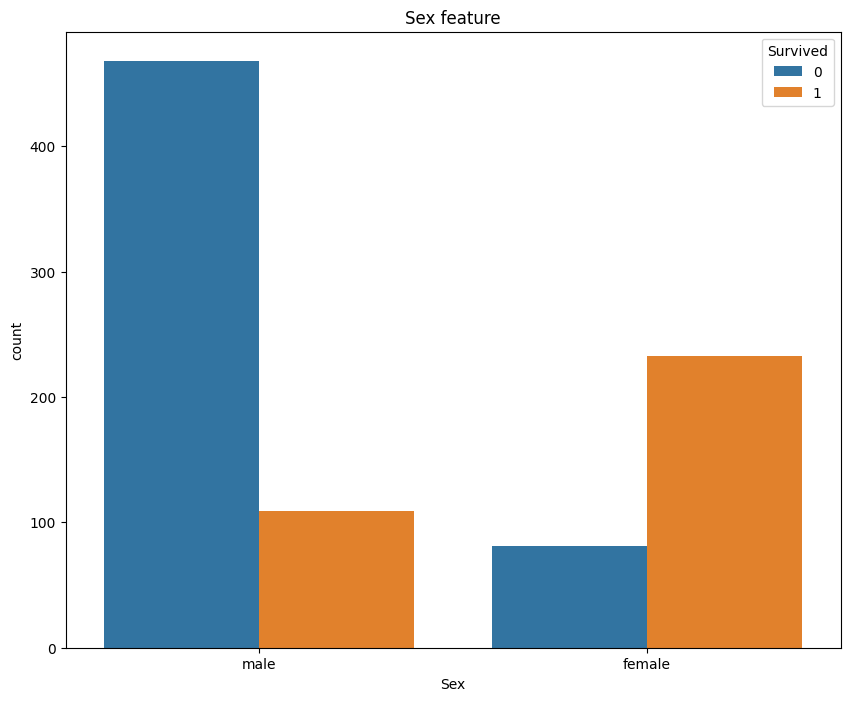

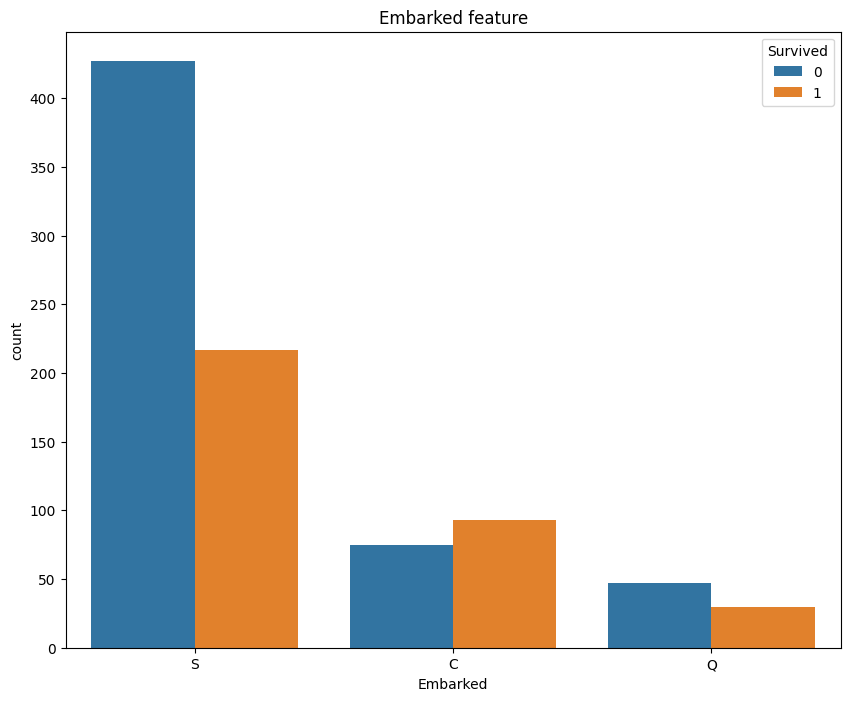

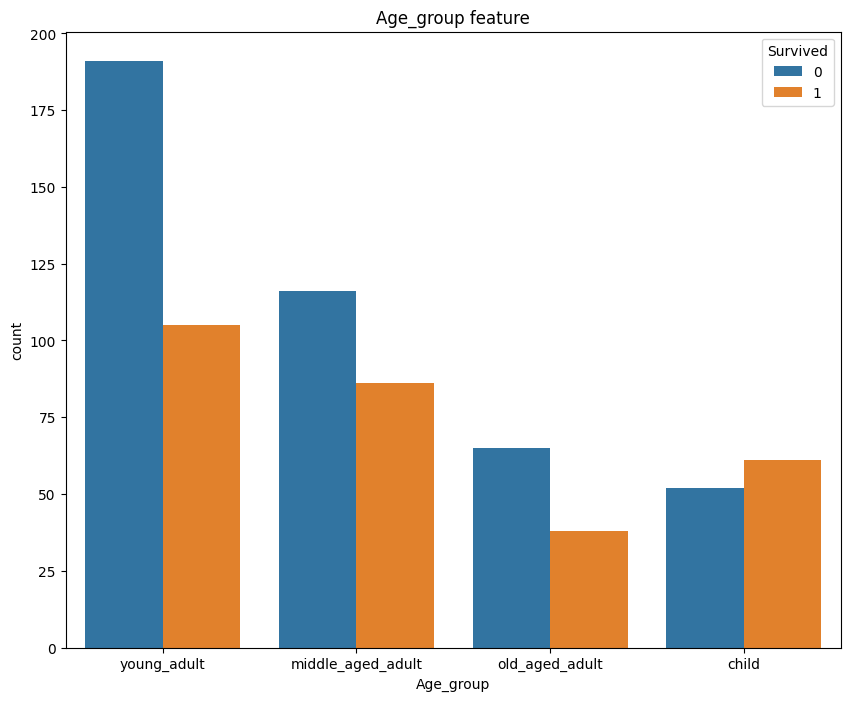

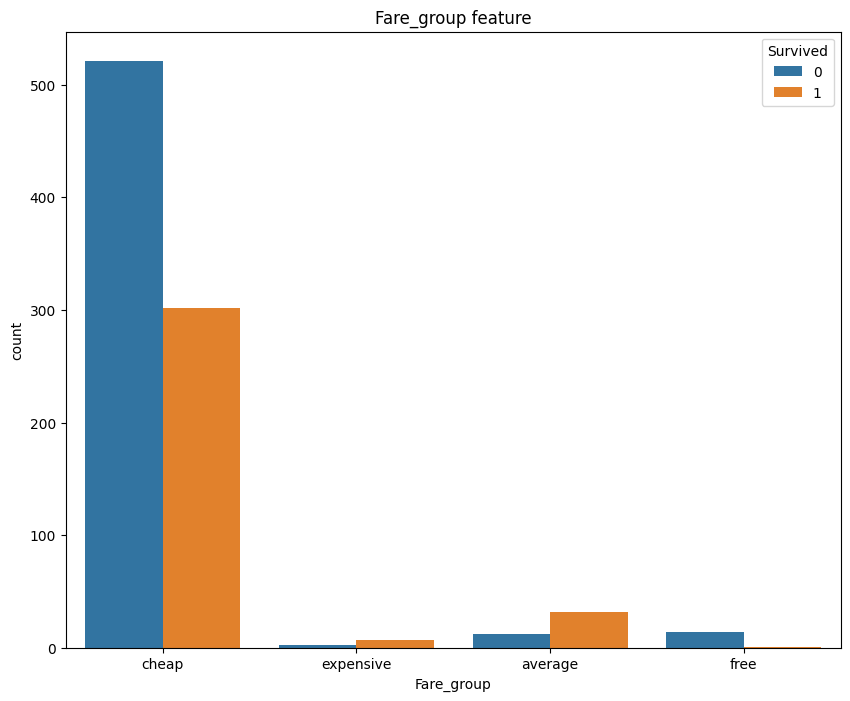

In [25]:
for feat in cat_feat:
    sns.countplot(data_copy, hue = 'Survived', x = feat).set(title = f"{feat} feature")
    plt.show()
    

In [58]:
data_copy['Survived'] / data_copy.groupby('Embarked')['Survived'].transform('sum')

0      0.000000
1      0.010753
2      0.004608
3      0.004608
4      0.000000
         ...   
886    0.000000
887    0.004608
888    0.000000
889    0.010753
890    0.000000
Name: Survived, Length: 891, dtype: float64

In [71]:
data_copy.groupby('Embarked').agg({'Survived' : 'sum'})['Survived'].sort_values(ascending = False).values

array([217,  93,  30])

In [72]:
data_copy['Embarked'].value_counts().values

array([644, 168,  77])

In [77]:
data_copy['Embarked'].value_counts().index.to_list()

['S', 'C', 'Q']

In [85]:
c = pd.DataFrame(
             zip(data_copy['Embarked'].value_counts().index.to_list(),
             data_copy['Embarked'].value_counts().values, 
             data_copy.groupby('Embarked').agg({'Survived' : 'sum'})['Survived'].sort_values(ascending = False).values),
             columns = ['Embarked', 'Count', 'Survived_count']
            )

In [86]:
c

,Embarked,Count,Survived_count
0,S,644,217
1,C,168,93
2,Q,77,30


In [89]:
c['Perc'] = (c['Survived_count'] / c['Count'] ) * 100

In [93]:
c

,Embarked,Count,Survived_count,perc,Perc
0,S,644,217,33.695652,33.695652
1,C,168,93,55.357143,55.357143
2,Q,77,30,38.961039,38.961039


Observations 
- More males died 
- More passenger who embarked from Cherbourg survived than died 

##### HYPOTHESIS 
Likely to survive 
- Children 
- Passengers who paid at least 101 in fare 
- Passengers traveling with one sibling/spouse/parent/child 
- Females 
- Passengers who embarked from Cherbourg

### FEATURE ENGINEERING AND SELECTION

##### FEATURE TRANSFORMATION  PIPLINE

- impute embarked feature 
- impute age feature 
- create age_group feature
- create fare_group feature
- create a feature that combines SibSp and Parch
- encode categorical features

In [26]:
# Embarked
data_copy[data_copy['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_group,Fare_group
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,middle_aged_adult,cheap
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,old_aged_adult,cheap


In [27]:
# Embarked 
data_copy['Embarked'].value_counts() 

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [28]:
data_copy.query("Pclass == 1 & Sex == 'female' & \
           Fare_group == 'cheap' & Survived == 1")['Embarked'].value_counts().index[0]

'S'

- Most people emarked from Southampton. Missing data in this feature will be filled with this value  

In [29]:
# AGE 
data_copy.groupby(['Sex', 'Pclass'])['Age'].mean().round(1)

Sex     Pclass
female  1         34.6
        2         28.7
        3         21.8
male    1         41.3
        2         30.7
        3         26.5
Name: Age, dtype: float64

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [31]:
class transformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def impute_age(self, cols):
        age = cols[0]
        sex = cols[1]
        pclass = cols[2]
        if pd.isna(age):
            if sex == 'female' and pclass == 1:
                return 34.6
            elif sex == 'female' and pclass == 2:
                return 28.7

            elif sex == 'female' and pclass == 3:
                return 28.7

            elif sex == 'male' and pclass == 1:
                return 41.3

            elif sex == 'male' and pclass == 2:
                return 30.7

            elif sex == 'male' and pclass == 3:
                return 26.5

        else:
            return age
        
    def age_groups(self, col):
        if col <= 17:
            return 'child'

        elif col == 18 or col <= 30:
            return 'young_adult'

        elif col == 31 or col <= 45:
            return 'middle_aged_adult'

        elif col >= 45:
            return 'old_aged_adult'
        else:
            return col    
        
    def fare_groups(self, col):
        if col == 0:
            return 'free'      
        elif col == 1 or col <= 100:
            return 'cheap'      
        elif col == 101 or col <= 250:
            return 'average'      
        elif col >= 251:
            return 'expensive'
        else:
            return col
        
    def reduce(self, cols):
        sibsp = cols[0]
        parch = cols[1]
        return sibsp + parch    
    
    def transform(self, X, y = None):
        X_copy = X.copy() 
        X_copy['Accompanied'] =  X_copy[['SibSp', 'Parch']].apply(self.reduce, axis = 1)
        X_copy['Age'] =  X_copy[['Age', 'Sex', 'Pclass']].apply(self.impute_age, axis = 1)
        X_copy['Age_group'] = X_copy['Age'].apply(self.age_groups)
        X_copy['Embarked'].fillna(data.Embarked.value_counts().index[0])
        X_copy['Fare_group'] = X_copy['Fare'].apply(self.fare_groups)
        
        return X_copy

In [32]:
transform = Pipeline([('transform', transformer())])

##### APPLYING TRANSFORMATION ON TRAIN AND TEST DATA

In [94]:
data_transformed = transform.transform(data_copy.copy())[['Survived', 'Pclass', 'Sex', 'Accompanied',
                  'Age_group', 'Fare_group']]

In [95]:
data_transformed

,Survived,Pclass,Sex,Accompanied,Age_group,Fare_group
0,0,3,male,1,young_adult,cheap
1,1,1,female,1,middle_aged_adult,cheap
2,1,3,female,0,young_adult,cheap
3,1,1,female,1,middle_aged_adult,cheap
4,0,3,male,0,middle_aged_adult,cheap
...,...,...,...,...,...,...
886,0,2,male,0,young_adult,cheap
887,1,1,female,0,young_adult,cheap
888,0,3,female,3,young_adult,cheap
889,1,1,male,0,young_adult,cheap


### MODEL BUILDING 

In [35]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, truncnorm, randint


In [96]:
inputs = data_transformed.copy().drop('Survived', axis = 1)
target = data_transformed['Survived']

In [97]:
inputs.head()

,Pclass,Sex,Accompanied,Age_group,Fare_group
0,3,male,1,young_adult,cheap
1,1,female,1,middle_aged_adult,cheap
2,3,female,0,young_adult,cheap
3,1,female,1,middle_aged_adult,cheap
4,3,male,0,middle_aged_adult,cheap


In [38]:
target.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [41]:
inputs.Fare_group.unique()

array(['cheap', 'expensive', 'average', 'free'], dtype=object)

In [98]:
age_group = ['old_aged_adult', 'middle_aged_adult', 'young_adult', 'child']
fare_group = ['expensive', 'average', 'cheap', 'free']

In [101]:
# CAT ENCODING 
cat_encoding = ColumnTransformer([
                                ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ['Sex']),
                                ('ordinal_enc', OrdinalEncoder(categories = [age_group, fare_group]), ['Age_group', 'Fare_group'])
                                ], remainder = 'passthrough')

RANDOM FOREST accuracy: 0.8058439520431863
-------------------------------------------


/Users/Labi/.local/share/virtualenvs/practice_sessions-qLYXlifg/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Labi/.local/share/virtualenvs/practice_sessions-qLYXlifg/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Labi/.local/share/virtualenvs/practice_sessions-qLYXlifg/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LOGISTIC REGRESSION accuracy: 0.8002259745150964
-------------------------------------------
SUPPORT VECTOR MACHINE accuracy: 0.8204004770573097
-------------------------------------------


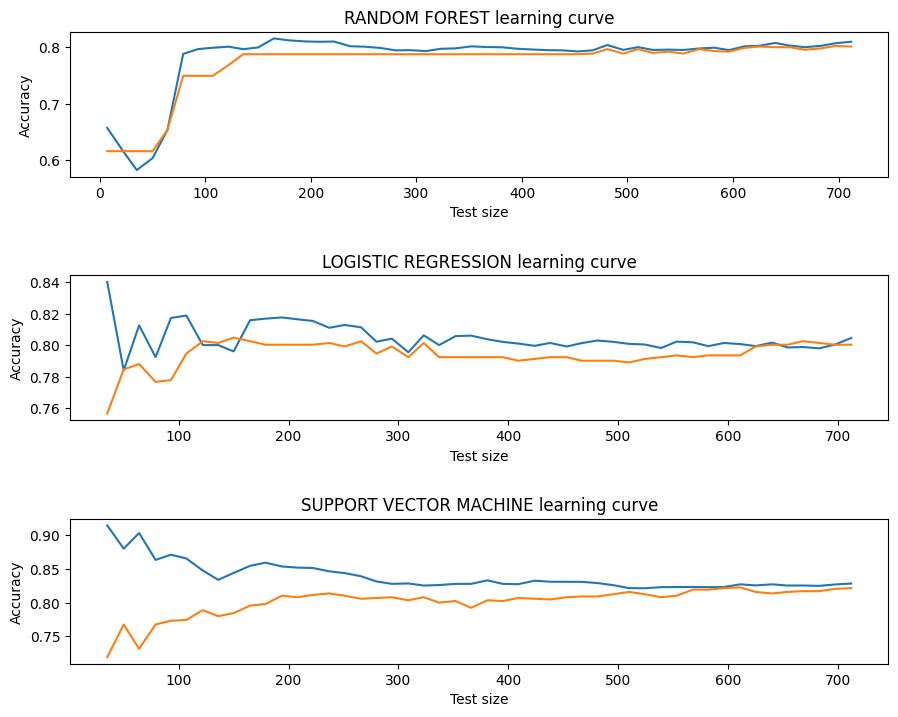

In [102]:
models = [RandomForestClassifier(), LogisticRegression(), SVC(probability = True)] 

model_names = ['RANDOM FOREST', 'LOGISTIC REGRESSION', 'SUPPORT VECTOR MACHINE']

rf_tuning_params = {
                    'model__max_depth': randint(1, 20),
                    'model__min_samples_leaf': randint(5, 100),
                    'model__criterion': ["gini", "entropy"]
                    }
lr_tuning_params = {
                    'model__C' : uniform(0.1, 20),
                    'model__solver' : ['newton-cg','sag','saga'],
                    'model__max_iter' :  randint(100, 10000)
                    }
sv_tuning_params = {
                    'model__C': uniform(0.1, 100), 
                    'model__kernel': ['rbf', 'poly', 'sigmoid']
                    }

params = [rf_tuning_params, lr_tuning_params, sv_tuning_params]

fig, ax = plt.subplots(3)
fig.tight_layout(pad=5)

models_tuned = []
for model, name, param, index  in zip(models, model_names, params, range(len(models))):
    pipe = Pipeline([('cat_encoding', cat_encoding),
                 ('model', model)])
    tuning = RandomizedSearchCV(pipe, param, n_iter = 10, cv = 5, scoring = 'accuracy')
    tuning.fit(inputs, target)
    print(f"{name} accuracy: {tuning.best_score_}")
    models_tuned.append(tuning.best_estimator_)
    train_size, train_score, test_score = learning_curve(tuning.best_estimator_,
                                                     inputs, target, cv = 5, 
                                                     scoring = 'accuracy',
                                                     n_jobs = -1, train_sizes = np.linspace(0.01,1,50))
    train_mean = np.mean(train_score, axis=1)
    train_std = np.std(train_score, axis=1)
    val_mean = np.mean(test_score, axis=1)
    val_std = np.std(test_score, axis=1)
    
    if index == 0:
        ax[0].plot(train_size, train_mean)
        ax[0].plot(train_size, val_mean)
        ax[0].set_title(f"{name} learning curve")
        ax[0].set_xlabel('Test size')
        ax[0].set_ylabel('Accuracy')
    elif index == 1:
        ax[1].plot(train_size, train_mean)
        ax[1].plot(train_size, val_mean)   
        ax[1].set_title(f"{name} learning curve")
        ax[1].set_xlabel('Test size')
        ax[1].set_ylabel('Accuracy')
    elif index == 2:
        ax[2].plot(train_size, train_mean)
        ax[2].plot(train_size, val_mean)
        ax[2].set_title(f"{name} learning curve")
        ax[2].set_xlabel('Test size')
        ax[2].set_ylabel('Accuracy')
    
        
    print('-------------------------------------------')
    
    

In [52]:
models_tuned

[Pipeline(steps=[('cat_encoding',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('one hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['Sex', 'Embarked',
                                                    'Age_group',
                                                    'Fare_group'])])),
                 ('model',
                  RandomForestClassifier(max_depth=12, min_samples_leaf=6))]),
 Pipeline(steps=[('cat_encoding',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('one hot',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['Sex', 'Embarked',
                                                    'Age_group',
                                                    'Fa

In [53]:
voting = VotingClassifier([('rf', models_tuned[0]), ('lr', models_tuned[1]),
('svc', models_tuned[2])], voting='hard', n_jobs=4)

voting.fit(inputs, target)

VotingClassifier(estimators=[('rf',
                              Pipeline(steps=[('cat_encoding',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('one '
                                                                                'hot',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['Sex',
                                                                                 'Embarked',
                                                                                 'Age_group',
                                                                                 'Fare_group'])])),
                                              ('model',
                                               RandomForestClassifier(max_depth=12,
                                                                      min_samples_leaf=6))])),
                             ('lr',
                              Pipeline(steps=[('cat_encoding',
                                               ColumnTransformer(rem...
                                                                                 'Fare_group'])])),
                                              ('model',
                                               LogisticRegression(C=9.085797268157519,
                                                                  max_iter=9570,
                                                                  solver='saga'))])),
                             ('svc',
                              Pipeline(steps=[('cat_encoding',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('one '
                                                                                'hot',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['Sex',
                                                                                 'Embarked',
                                                                                 'Age_group',
                                                                                 'Fare_group'])])),
                                              ('model',
                                               SVC(C=7.101959068889041,
                                                   probability=True))]))],
                 n_jobs=4)

##### HOLD OUT SET

In [62]:
test = pd.read_csv('test.csv')

In [64]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [65]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [74]:
test[test.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [85]:
test.query("Pclass == 3 & Sex == 'male' & Embarked == 'S'")['Fare'].mean().round(4)

12.7189

In [87]:
test.Fare.fillna(test.query("Pclass == 3 & Sex == 'male' & Embarked == 'S'")['Fare'].mean().round(4), inplace = True)

In [89]:
test[test.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [90]:
test_transformed = transform.transform(test.copy())[['Pclass', 'Sex', 'Accompanied',
                 'Embarked', 'Age_group', 'Fare_group']]

In [91]:
test_transformed.head()

,Pclass,Sex,Accompanied,Embarked,Age_group,Fare_group
0,3,male,0,Q,middle_aged_adult,cheap
1,3,female,1,S,old_aged_adult,cheap
2,2,male,0,Q,old_aged_adult,cheap
3,3,male,0,S,young_adult,cheap
4,3,female,2,S,young_adult,cheap


In [94]:
predictions = voting.predict(test_transformed)

In [100]:
results =pd.concat([test['PassengerId'], pd.Series(predictions, name = 'Survived')], axis = 1)

In [101]:
results

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [103]:
results.to_csv("titanic.csv",index=False)